# Lab 6 - Model comparison

In this excercise we will learn about comparing models using metrics predicting out of sample behavior.

Main idea is to instead of splitting the dataset into two parts (test and training set) to estimate how model would behave in presence of new data.
This is being done by evaluating so called *log likelihood* which is an array of values of logarithm of likelihood for each of datapoints individually.

We will use this informations with two metrics:
- Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model
- PSIS-LOOCV - Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time. 

For this excercise code is provided in form of print-screens. 

### Excercise 1 - generate data


F - number of letters in first name

L - number of letters in last name

N = (L+F)*100

1. Compile code_1.stan and  code_2.stan 
2. Generate data for rest of excercises.

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
F = 5
L = 5

N = (L+F)*100

In [3]:
gen_quant = CmdStanModel(stan_file='code_1.stan')
samples = gen_quant.sample(data={'N':N},
                        seed=20042023,
                        fixed_param=True,
                        iter_sampling=1, 
                        iter_warmup=0,
                        chains=1)
df1 = samples.draws_pd()
df1.describe()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
count,1.0,1.0,1.00,1.00000,1.0000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000,1.000000
mean,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451
25%,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451
50%,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451
75%,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451
max,0.0,0.0,0.01,-1.28574,15.7368,-0.607976,0.850032,1.69014,-0.016158,0.783106,...,-1.08032,-1.80201,2.00713,0.582892,0.936565,0.724766,-0.3138,2.97671,0.966663,-0.299451


In [4]:
gen_quant_2 = CmdStanModel(stan_file='code_2.stan')
samples_2 = gen_quant_2.sample(data={'N':N},
                        seed=20042023,
                        fixed_param=True,
                        iter_sampling=1, 
                        iter_warmup=0,
                        chains=1)
df2 = samples_2.draws_pd()
df2.describe()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
count,1.0,1.0,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.000000
mean,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768
25%,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768
50%,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768
75%,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768
max,0.0,0.0,-1.28574,0.847453,-0.84245,-1.22122,1.24276,1.52911,-0.016158,0.58767,...,-6.04456,-2.84629,2.31649,-3.80647,-3.59574,-4.77386,0.892875,4.34195,1.39113,-0.355768



### Excercise 2 - compare normal and student models for data from first file


1. Compile both models
2. Fit both models
3. Using az.compare and az.plot_compare analyze both models using ```loo``` and ```waic``` criteria. 

In [5]:
gen_quant_3 = CmdStanModel(stan_file='code_3.stan')
y_1 = df1.loc[:, 'y[1]':'y[1000]'].values.flatten()
samples_3 = gen_quant_3.sample(data={'N':N, "y": y_1.reshape((N,))},
                        seed=20042023)
df3 = samples_3.draws_pd()
df3

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-2030.35,0.946684,0.921356,2.0,7.0,0.0,2031.87,1.87363,0.037430,-1.79618,...,1.935970,0.577024,-0.391437,-0.329822,0.095173,2.117700,-2.441170,-0.662482,0.188946,-1.214790
1,-2029.29,0.761810,0.921356,2.0,3.0,0.0,2032.79,1.82732,0.127183,-1.82073,...,-2.603250,1.573710,-0.098060,1.549270,3.553020,0.419775,2.834090,-2.932580,0.884203,0.621078
2,-2029.86,0.924989,0.921356,2.0,3.0,0.0,2030.01,1.81476,0.056263,-1.78832,...,-0.682716,4.586120,-2.300210,1.774530,1.623550,-1.454650,-0.155956,-3.495040,-2.145140,-0.646333
3,-2030.28,0.873341,0.921356,2.0,3.0,0.0,2031.38,1.82670,0.029265,-1.78056,...,-2.160290,0.896906,2.502960,0.205636,2.040040,0.954149,0.450186,-1.017340,3.299310,-0.043766
4,-2029.82,1.000000,0.921356,2.0,3.0,0.0,2030.59,1.88329,0.130038,-1.83453,...,2.628550,0.068251,-1.177750,-1.398490,1.321250,0.799318,-2.024920,3.071870,0.097084,2.227460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2029.54,0.855158,0.801120,1.0,3.0,0.0,2031.41,1.85157,0.067650,-1.80211,...,3.881360,-1.218300,2.137090,-1.051850,1.892630,-0.631840,2.903750,0.934863,2.915080,-0.015494
3996,-2029.41,0.926203,0.801120,2.0,3.0,0.0,2030.39,1.86168,0.130577,-1.82981,...,-1.748490,2.071390,3.058410,0.539956,0.213265,-0.314129,2.855620,-0.541883,-0.020334,0.347779
3997,-2029.23,1.000000,0.801120,2.0,3.0,0.0,2029.40,1.83346,0.119914,-1.81903,...,-0.797388,-1.817450,0.410113,1.969280,-0.967699,0.544361,2.460510,-0.390918,-1.556000,1.412060
3998,-2029.25,0.995894,0.801120,2.0,3.0,0.0,2029.28,1.85041,0.109336,-1.81855,...,0.975295,-0.394585,-0.383230,4.314630,0.415851,0.551597,-2.807970,2.007320,1.463190,1.671600


In [6]:
gen_quant_4 = CmdStanModel(stan_file='code_4.stan')
y_2 = df2.loc[:, 'y[1]':'y[1000]'].values.flatten()
samples_4 = gen_quant_4.sample(data={'N':N, "y": y_2.reshape((N,))},
                        seed=20042023)
df4 = samples_4.draws_pd()
df4

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-2326.71,0.946782,0.810388,2.0,7.0,0.0,2327.30,2.37428,-0.118711,61.3032,...,1.007430,-0.598769,0.780687,-1.638650,-1.209620,0.852084,-1.22098,0.366243,-0.217660,-5.453100
1,-2325.99,0.956932,0.810388,3.0,7.0,0.0,2328.28,2.39288,-0.038570,22.3231,...,3.269090,-1.316140,0.518231,0.171736,0.744039,1.328000,2.51030,0.209058,2.904430,-0.931830
2,-2326.14,0.861044,0.810388,2.0,7.0,0.0,2327.72,2.47484,-0.049223,32.0820,...,0.514011,-3.221350,-0.872294,-1.810220,-2.734000,3.735040,-2.77818,-1.103780,-4.046590,-3.369920
3,-2327.03,0.953417,0.810388,3.0,7.0,0.0,2327.72,2.36937,0.064325,37.2203,...,-0.117559,-0.088784,1.237830,3.705320,0.812707,-0.472970,2.82145,-3.084550,1.312310,-1.574900
4,-2326.07,1.000000,0.810388,1.0,1.0,0.0,2326.87,2.38010,0.023498,36.7019,...,-3.449000,3.448600,1.344140,2.422760,0.234463,-0.335177,3.48016,-0.097209,-2.399540,-4.420560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2328.51,0.930451,0.727213,2.0,7.0,0.0,2330.11,2.43659,-0.186176,84.1224,...,-1.785370,0.276498,-1.208710,-0.140334,1.665440,0.730094,-1.63940,2.123020,-2.535910,-7.490270
3996,-2328.70,0.982252,0.727213,3.0,7.0,0.0,2329.84,2.23950,-0.046569,19.0095,...,3.776110,5.772960,-3.193460,5.163940,2.738660,-0.514613,-1.05791,1.981590,1.205240,-1.450060
3997,-2327.94,1.000000,0.727213,2.0,3.0,0.0,2329.45,2.30071,-0.019530,15.0596,...,-1.210610,-3.736350,2.657360,-2.493670,2.016060,-3.430170,-2.06082,-2.193100,0.074082,-0.891209
3998,-2327.66,1.000000,0.727213,1.0,1.0,0.0,2328.07,2.30775,-0.017493,15.7739,...,-1.844130,1.273390,-4.718180,1.927910,-1.505450,5.792200,-1.34733,-1.156510,2.589560,1.296980


In [7]:
az_data_3 = az.from_cmdstanpy(samples_3)
az_data_4 = az.from_cmdstanpy(samples_4)

In [8]:
az_data_3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [9]:
az_data_4

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0.5, 1.0, 'Loo criterion')

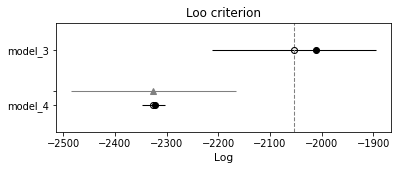

In [10]:
comp_1 = az.compare({"model_3": az_data_3, "model_4": az_data_4}, ic="loo")
ax = az.plot_compare(comp_1)
ax.set_title("Loo criterion")

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Text(0.5, 1.0, 'WAIC criterion')

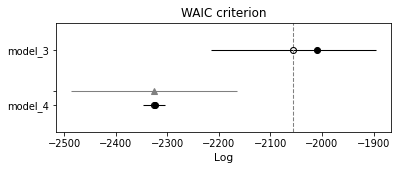

In [11]:
comp_1 = az.compare({"model_3": az_data_3, "model_4": az_data_4}, ic="waic")
ax = az.plot_compare(comp_1)
ax.set_title("WAIC criterion")

### Excercise 3 - compare models with different numbers of predictors
```code_5.stan```



1. Compile model
2. Compare models for 1, 2 and 3 predictors as in previous excercise

In [12]:
X_2_1 = df2.loc[:, 'X[1,1]':'X[1000,1]'].values.reshape((N,1))
X_2_2 = df2.loc[:, 'X[1,1]':'X[1000,2]'].values.reshape((N,2))
X_2_3 = df2.loc[:, 'X[1,1]':'X[1000,3]'].values.reshape((N,3))
y_2 =   df2.loc[:, 'y[1]':'y[1000]'].values.reshape((N,))

In [13]:
gen_quant_5 = CmdStanModel(stan_file='code_5.stan')
samples_5_1 = gen_quant_5.sample(data={'N': N, 'K': 1, 'y': y_2, 'X': X_2_1},
                        seed=20042023)
df5_1 = samples_5_1.draws_pd()
df5_1

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],mu[1],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-896.507,0.882479,0.891427,2.0,3.0,0.0,896.955,1.53364,1.97999,-2.54576,...,-4.393890,-4.14141,2.241600,-1.492670,-4.142690,-1.411080,0.742364,2.27148,1.621720,-0.656310
1,-898.579,0.687727,0.891427,2.0,3.0,0.0,901.154,1.48123,2.04693,-2.63182,...,-3.455430,-1.52569,2.578690,-4.022340,-2.454180,-4.220800,0.495507,3.21224,0.642240,-0.547575
2,-895.330,1.000000,0.891427,2.0,3.0,0.0,898.023,1.50907,1.87906,-2.41598,...,-2.263230,-3.38149,0.440991,-2.180300,-1.624790,-2.618690,0.316496,2.39287,-1.138010,-0.184783
3,-894.774,0.933900,0.891427,1.0,3.0,0.0,895.904,1.47662,1.93384,-2.48641,...,-2.176440,-2.02884,-0.588157,-2.644950,-0.915108,-4.204010,1.155220,3.30918,2.294580,-1.498460
4,-894.764,0.843824,0.891427,2.0,3.0,0.0,896.124,1.47667,1.90747,-2.45251,...,-4.395350,-3.89531,1.521620,-3.610960,-4.360290,-5.390930,1.209430,3.10971,0.569035,-0.573774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-898.016,0.733221,0.810692,2.0,3.0,0.0,898.434,1.50726,2.03563,-2.61729,...,-3.943260,-4.48187,0.990743,-1.389760,-1.558390,-2.572140,0.019162,3.89916,0.042651,-0.564245
3996,-894.967,1.000000,0.810692,2.0,3.0,0.0,897.850,1.46173,1.92811,-2.47904,...,-0.262174,-3.81588,1.145980,-2.321600,-3.185650,0.263135,-1.233910,3.47088,1.165710,-3.326860
3997,-895.022,0.982031,0.810692,2.0,3.0,0.0,895.281,1.46212,1.90193,-2.44538,...,-1.252280,-4.59741,-0.285279,-0.990695,0.713123,-2.664820,0.760443,3.48996,1.058410,1.128100
3998,-894.843,0.990415,0.810692,2.0,3.0,0.0,895.155,1.46964,1.90746,-2.45250,...,-4.508750,-3.51063,0.229246,-2.018570,-1.433130,-3.734550,-2.094250,2.20941,1.892310,-0.434607


In [14]:
samples_5_2 = gen_quant_5.sample(data={'N': N, 'K': 2, 'y': y_2, 'X': X_2_2},
                        seed=20042023)
df5_2 = samples_5_2.draws_pd()
df5_2

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],beta[2],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1404.50,0.824278,0.795741,3.0,7.0,0.0,1407.05,2.43178,-0.004321,-0.165373,...,-4.044020,0.111785,-0.730072,-4.767130,1.499590,0.774820,1.728990,-0.731865,0.440045,2.182730
1,-1402.99,1.000000,0.795741,3.0,7.0,0.0,1404.45,2.47542,0.050512,-0.053253,...,1.369420,-2.988930,-2.465280,2.236510,7.573860,4.049870,-2.018240,-1.637150,-1.499510,-2.784140
2,-1402.92,0.883133,0.795741,3.0,7.0,0.0,1404.42,2.47063,-0.049175,0.002821,...,1.875930,4.131160,3.503080,3.258730,-4.310810,-1.370040,-1.501570,-1.262440,1.941720,-2.334020
3,-1403.44,0.771505,0.795741,1.0,3.0,0.0,1405.32,2.47018,0.060729,-0.098656,...,-0.943805,0.325088,1.150050,1.900500,-1.642070,3.713600,2.667480,-3.659290,-1.265780,4.133620
4,-1402.89,1.000000,0.795741,2.0,3.0,0.0,1403.46,2.47081,0.011595,-0.077564,...,1.137020,3.954920,-2.660880,1.637100,-3.805620,-1.385230,2.696920,-3.389800,0.167070,-1.632700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1405.52,0.614395,0.840610,2.0,3.0,0.0,1408.09,2.50986,0.170774,0.008173,...,-1.276700,-0.529233,-2.074290,2.058170,1.370410,-2.413040,-4.937290,-2.497140,-5.318690,1.141220
3996,-1405.52,0.810009,0.840610,1.0,1.0,0.0,1406.70,2.50986,0.170774,0.008173,...,0.173561,-1.944640,-0.631402,-1.536900,4.078690,-2.865840,-2.108390,0.706823,-1.938430,-2.563120
3997,-1403.84,0.962421,0.840610,2.0,3.0,0.0,1406.54,2.52982,0.051775,-0.093773,...,-1.406190,0.329709,-0.759613,-1.603630,-2.731450,4.635180,1.278070,-4.731330,-0.548350,1.330830
3998,-1404.63,0.926730,0.840610,2.0,3.0,0.0,1405.38,2.40137,-0.036673,0.081199,...,1.174460,3.020000,1.359910,0.018666,-1.176250,0.501114,1.783500,0.906675,-0.589644,-0.918872


In [15]:
samples_5_3 = gen_quant_5.sample(data={'N': N, 'K': 3, 'y': y_2, 'X': X_2_3},
                        seed=20042023)
df5_3 = samples_5_3.draws_pd()
df5_3

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta[1],beta[2],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1403.84,0.982250,0.838881,3.0,7.0,0.0,1405.83,2.39590,0.159154,-0.007569,...,-0.154246,1.090290,-5.654000,-0.588623,2.123630,1.446820,2.904680,-2.541890,-1.510610,1.260410
1,-1398.76,1.000000,0.838881,3.0,7.0,0.0,1403.59,2.51574,0.130649,0.023926,...,1.452360,-1.674560,-0.606410,-3.276240,-0.597180,4.372340,0.943081,-5.510890,2.412160,-0.778943
2,-1399.00,0.980938,0.838881,3.0,7.0,0.0,1399.57,2.38288,0.057567,0.056748,...,-3.432390,0.005077,-1.128860,-3.133910,-1.543110,-1.885910,-0.997177,2.678860,-3.260170,2.108380
3,-1399.21,0.581197,0.838881,1.0,3.0,0.0,1404.02,2.54543,0.085616,0.055561,...,-1.384170,-5.713340,-1.766740,2.152230,-0.003159,2.087700,1.699280,-2.177270,0.548979,-1.021470
4,-1400.86,0.894738,0.838881,2.0,3.0,0.0,1401.25,2.58205,0.013468,0.072218,...,-4.307840,-2.314740,-2.238670,-0.182179,3.766690,-0.174388,4.111530,0.748646,3.069530,-1.912510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1398.93,0.995679,0.888765,3.0,7.0,0.0,1400.02,2.44109,0.062885,0.117973,...,-0.449888,-0.531732,-1.293650,-1.687270,-0.121447,0.792654,3.816780,4.888010,0.422674,0.424985
3996,-1400.53,0.718639,0.888765,2.0,3.0,0.0,1401.96,2.36198,0.162244,0.107788,...,-2.337790,1.019750,-0.131838,-2.496420,1.814740,0.641725,-3.651050,-2.497030,1.231690,-4.592630
3997,-1398.74,0.986817,0.888765,2.0,3.0,0.0,1401.21,2.47528,0.177154,0.055837,...,0.053660,-1.013280,-1.069490,-2.779250,4.013750,3.249280,-0.934842,-0.967326,2.520480,-0.852863
3998,-1399.11,0.929721,0.888765,2.0,3.0,0.0,1399.97,2.43558,-0.026823,0.034429,...,-2.412770,0.946479,-1.271980,-5.054420,-4.610080,2.282150,-0.824302,1.850310,-0.621999,-0.642301


In [16]:
az_data_5_1 = az.from_cmdstanpy(samples_5_1)
az_data_5_2 = az.from_cmdstanpy(samples_5_2)
az_data_5_3 = az.from_cmdstanpy(samples_5_3)

In [17]:
az_data_5_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [18]:
az_data_5_2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [19]:
az_data_5_3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

Text(0.5, 1.0, 'Loo criterion')

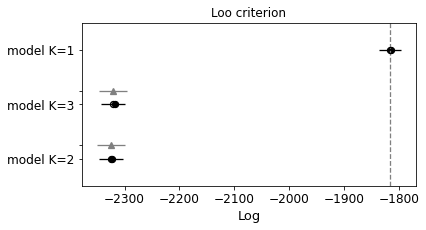

In [20]:
comp_1 = az.compare({"model K=1": az_data_5_1, "model K=2": az_data_5_2, "model K=3": az_data_5_3}, ic="loo")
ax = az.plot_compare(comp_1)
ax.set_title("Loo criterion")

Text(0.5, 1.0, 'Waic criterion')

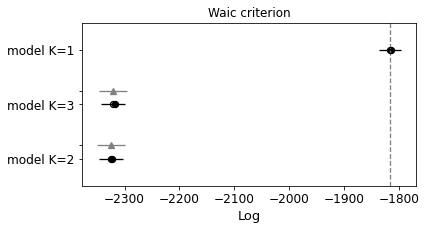

In [21]:
comp_2 = az.compare({"model K=1": az_data_5_1, "model K=2": az_data_5_2, "model K=3": az_data_5_3}, ic="waic")
ax = az.plot_compare(comp_2)
ax.set_title("Waic criterion")